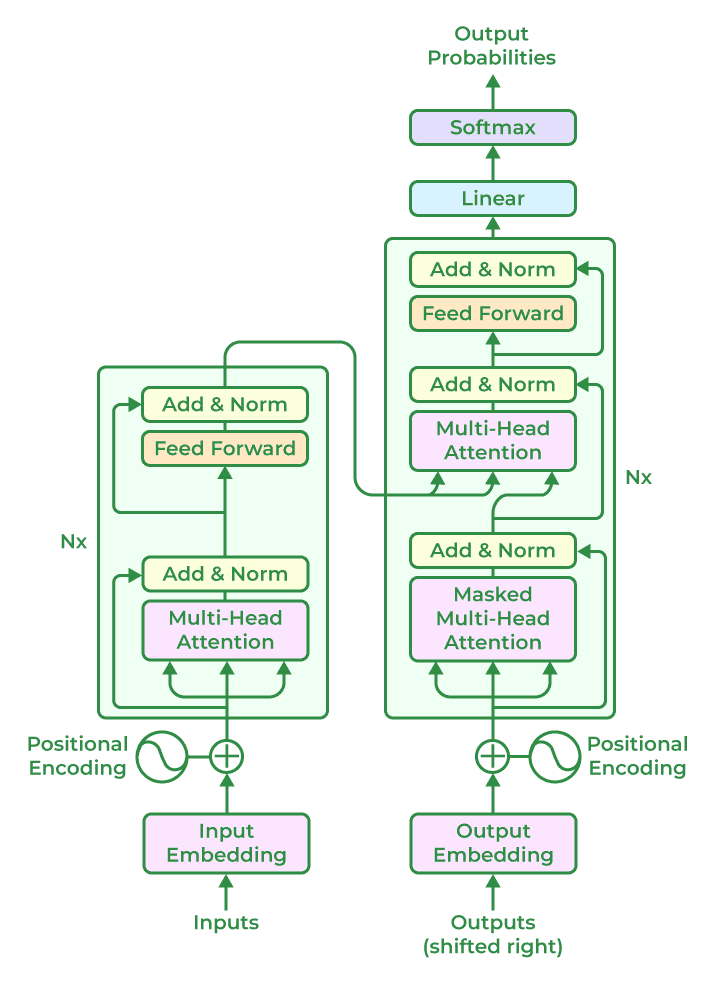

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.6.0+cpu'

In [3]:
torchvision.__version__

'0.21.0+cpu'

In [4]:
!nvidia-smi

Wed May 28 11:03:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.70                 Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro M4000M                WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   42C    P8             11W /  100W |    1525MiB /   4096MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# set device diagnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
print(f"Using device: {device}")

Using device: cpu


## Setting the seed

In [8]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

## Setting the hyper parameters

In [9]:
3e-4

0.0003

In [10]:
BATCH_SIZE = 128
EPOCHS = 10 # Try increasing epochs to 30
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32 # Transform the image and make the size go to 224
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8 # INcrease the number heads
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

## Define image transformations

In [11]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5), (0.5))
  # 1. Helps the model to converge faster
  # 2. Helps to make the numerical computations stable
])

transform_train = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
  transforms.ToTensor(),
  transforms.Normalize((0.5), (0.5))
])

transform_test = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5), (0.5))
])

## Getting a dataset

In [12]:
train_dataset = datasets.CIFAR10(
  root='./data',
  train=True,
  download=True,
  transform=transform
)

100%|██████████| 170M/170M [06:53<00:00, 412kB/s]  


In [13]:
test_dataset = datasets.CIFAR10(
  root='./data',
  train=False,
  download=True,
  transform=transform
)

In [14]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [15]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [16]:
len(train_dataset), len(test_dataset)

(50000, 10000)

##  Converting our datasets into dataloaders

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our data into batches or (mini-batches)

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memroy) at 50000 images in one hit. So we break it into 128 images at a time. (batch size of 128).
2. It gives our neural network more chances to update its gradients per epoch

In [17]:
train_loader = DataLoader(
  dataset=train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=True
)

test_loader = DataLoader(
  dataset=test_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False
)

In [18]:
# checking 
print(f"Dataloader: {len(train_loader)} batches, {len(test_loader)} batches")

Dataloader: 391 batches, 79 batches


## Building Vision Transformer model from scratch

In [19]:
class PatchEmbedding(nn.Module):
  def __init__(self,
                img_size,
                patch_size,
                in_channels,
                embed_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels=in_channels,
                          out_channels=embed_dim,
                          kernel_size=patch_size,
                          stride=patch_size)
    num_patches = (img_size // patch_size) ** 2
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

  def forward(self, x: torch.Tensor):
    B = x.size(0)
    x = self.proj(x) # (B, E, H/P, W/P)
    x = x.flatten(2).transpose(1, 2) # (B, N, E)
    cls_tokens = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    x = x + self.pos_embed
    return x

In [20]:
class MLP(nn.Module):
  def __init__(self,
                in_features,
                hidden_features,
                drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features=in_features,
                          out_features=hidden_features)
    self.fc2 = nn.Linear(in_features=hidden_features,
                          out_features=in_features)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    x = self.dropout(F.gelu(self.fc1(x)))
    x = self.dropout(self.fc2(x))
    return x

In [21]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self,embed_dim,num_heads,mlp_dim,drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim,num_heads,drop_rate,batch_first=True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim,mlp_dim,drop_rate)
    
  def forward(self,x):
    x = x + self.attn(self.norm1(x),self.norm1(x),self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x

In [22]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    self.encoder = nn.Sequential(*[
        TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
        for _ in range(depth)
    ])
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    return self.head(cls_token)

In [23]:
# instatiate a model
model = VisionTransformer(
    img_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=CHANNELS,
    num_classes=NUM_CLASSES,
    embed_dim=EMBED_DIM,
    depth=DEPTH,
    num_heads=NUM_HEADS,
    mlp_dim=MLP_DIM,
    drop_rate=DROP_RATE
).to(device)

In [24]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

## Defining a loss function and optimizer

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [26]:
criterion

CrossEntropyLoss()

In [27]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

## defining a training loop function

In [28]:
def train(model, train_loader, criterion, optimizer, device):
  # setting the model into training
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    
    # 1. forward pass
    outputs = model(images)
    # 2. compute the loss per batch
    loss = criterion(outputs, labels)
    # 3. backprop
    loss.backward()
    # 4. perform gradient descent algorithm
    optimizer.step()

    total_loss += loss.item() * images.size(0)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

  avg_loss = total_loss / total
  accuracy = correct / total
  return avg_loss, accuracy

In [29]:
def evaluate(model,loader):
  model.eval()
  correct = 0

  with torch.inference_mode():
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()

  accuracy = correct / len(loader.dataset)
  return accuracy

### Training

In [30]:
train_accuracies, test_accuracies = [], []

for epoch in range(EPOCHS):
  train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
  test_accuracy = evaluate(model, test_loader)

  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

  print(f"Epoch [{epoch+1}/{EPOCHS}], "
        f"Train Loss: {train_loss:.4f}, "
        f"Train Accuracy: {train_accuracy:.4f}, "
        f"Test Accuracy: {test_accuracy:.4f}")

Epoch [1/10], Train Loss: 1.7387, Train Accuracy: 0.3698, Test Accuracy: 0.4701
Epoch [2/10], Train Loss: 1.3869, Train Accuracy: 0.5032, Test Accuracy: 0.5302
Epoch [3/10], Train Loss: 1.2348, Train Accuracy: 0.5569, Test Accuracy: 0.5707
Epoch [4/10], Train Loss: 1.1360, Train Accuracy: 0.5942, Test Accuracy: 0.5879
Epoch [5/10], Train Loss: 1.0493, Train Accuracy: 0.6239, Test Accuracy: 0.6087
Epoch [6/10], Train Loss: 0.9656, Train Accuracy: 0.6561, Test Accuracy: 0.6070
Epoch [7/10], Train Loss: 0.8905, Train Accuracy: 0.6826, Test Accuracy: 0.6164
Epoch [8/10], Train Loss: 0.8212, Train Accuracy: 0.7064, Test Accuracy: 0.6366
Epoch [9/10], Train Loss: 0.7449, Train Accuracy: 0.7341, Test Accuracy: 0.6301
Epoch [10/10], Train Loss: 0.6732, Train Accuracy: 0.7606, Test Accuracy: 0.6197


In [31]:
print(f"Train accuracy: {train_accuracies[-1]:.4f}, "
      f"Test accuracy: {test_accuracies[-1]:.4f}")

Train accuracy: 0.7606, Test accuracy: 0.6197


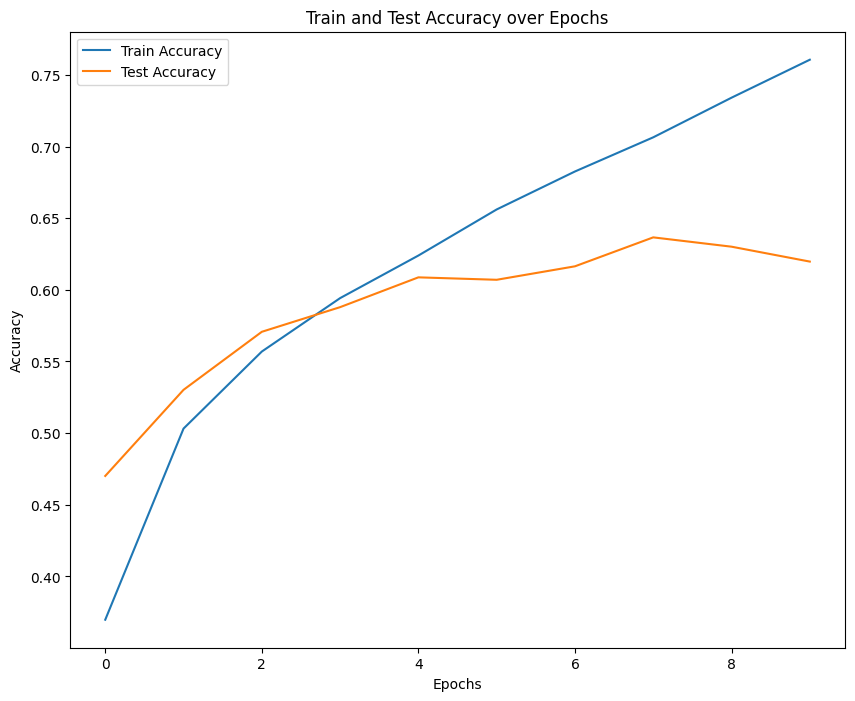

In [32]:
# plot accuracies
plt.figure(figsize=(10, 8))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy over Epochs')
plt.show()

In [33]:
import random

In [39]:
def predict(model, dataset, classes,grid_size=3):
  model.eval()
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0, len(dataset) - 1)
      image, label = dataset[idx]
      input_tensor = image.unsqueeze(dim=0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
      
      image = image / 2 + 0.5 # unnormalize the image to be able to visualize
      npimage = image.cpu().numpy()
      axes[i, j].imshow(npimage.transpose(1, 2, 0))  # <-- fixed
      truth = classes[label] == classes[predicted.item()]
      color = "g" if truth else "r"
      axes[i, j].set_title(f"True: {classes[label]}, Pred: {classes[predicted.item()]}", color=color,fontsize=10)
      axes[i, j].axis('off')
  plt.tight_layout()
  plt.show()

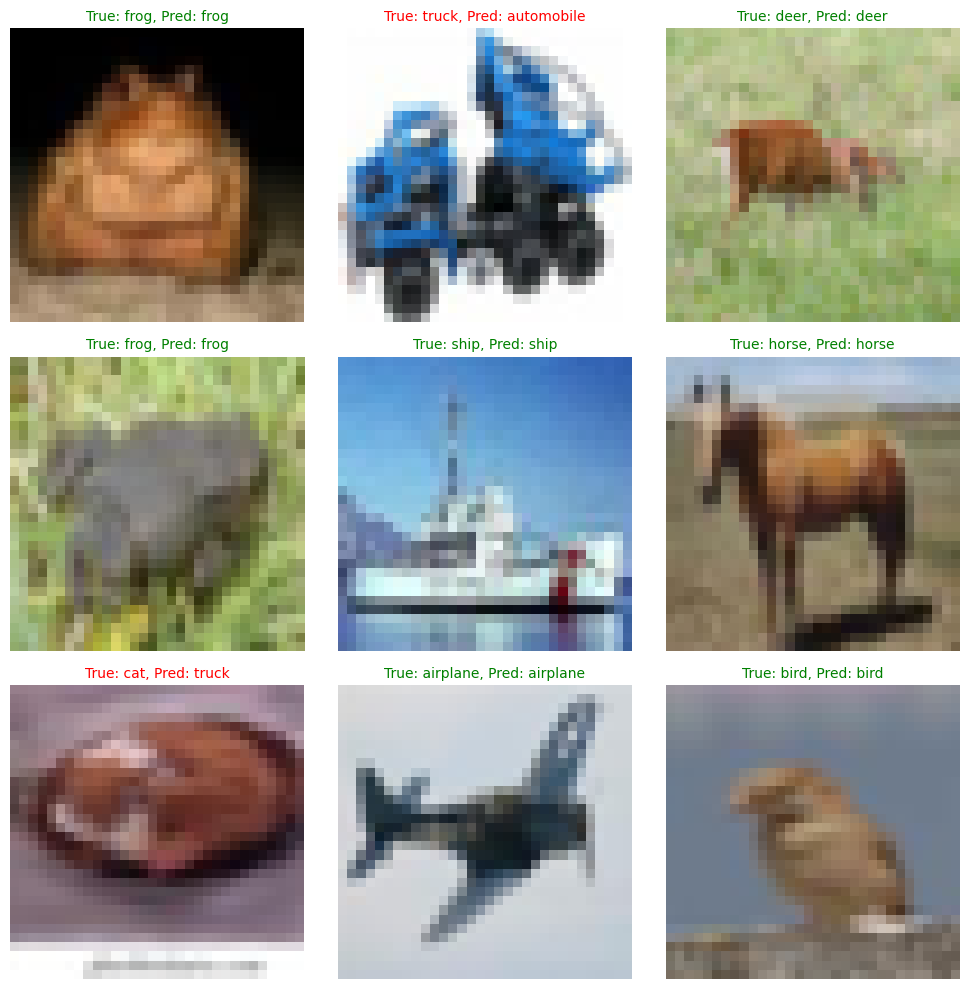

In [40]:
predict(model, test_dataset, train_dataset.classes, grid_size=3)
# If you still get an error, check the predict function and make sure this line:
# axes[i, j].imshow(npimage.transpose(1, 2, 0))